In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error,median_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
!pip install catboost
from catboost import CatBoostRegressor
import os
# Monter le Drive
from google.colab import drive
drive.mount('/content/drive')
# Changer de répertoire vers SteamAnalyse
project_dir = '/content/drive/MyDrive/SteamAnalyse'
os.chdir(project_dir)

path="train.parquet"
path_test="test.parquet"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.6 MB/s eta 0:00:00
Mounted at /content/drive


In [4]:
df = pd.read_parquet(path)
dft = pd.read_parquet(path_test)

In [5]:
def clean_text_col(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(i) for i in x])
    return str(x) if pd.notna(x) else ""

In [9]:
platforms = ["mac", "windows", "linux"]

for p in platforms:
    df[p] = df["plateformes"].apply(lambda x: int(p in x))
for p in platforms:
    dft[p] = dft["plateformes"].apply(lambda x: int(p in x))

In [14]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
cols_cat = ["mois","annee","mac",'linux',"windows"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols + cols_text + cols_cat
target = "review"

X_train = df[features].copy()
for c in cols_text: X_train[c] = X_train[c].apply(clean_text_col)
y_train = np.log1p(df[target])

In [18]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
cols_cat = ["mois","annee","mac",'linux',"windows"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols + cols_text + cols_cat
target = "review"

X_test = dft[features].copy()
for c in cols_text: X_test[c] = X_test[c].apply(clean_text_col)
y_test = df[target]

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet', 'description_detaillee']...
Learning rate set to 0.067142
0:	learn: 1.9981509	total: 349ms	remaining: 5m 49s
100:	learn: 1.0857114	total: 22.4s	remaining: 3m 19s
200:	learn: 1.0274076	total: 40.9s	remaining: 2m 42s
300:	learn: 0.9946998	total: 59.3s	remaining: 2m 17s
400:	learn: 0.9680497	total: 1m 17s	remaining: 1m 56s
500:	learn: 0.9511328	total: 1m 36s	remaining: 1m 35s
600:	learn: 0.9335536	total: 1m 54s	remaining: 1m 16s
700:	learn: 0.9206719	total: 2m 12s	remaining: 56.5s
800:	learn: 0.9104540	total: 2m 30s	remaining: 37.3s
900:	learn: 0.9002705	total: 2m 48s	remaining: 18.5s
999:	learn: 0.8911169	total: 3m 5s	remaining: 0us

🏆 SCORE FINAL (R2 Log) : 0.7463
RMSE: 4844.905477376106
RMSE log : 1.0297860811023967

 SCORE TRAIN (R2 Log) : 0.8152
Erreur Médiane : 2.56623865442878

Top Facteurs de Succès :
              Feature Id  Importances
0             categories    23.2

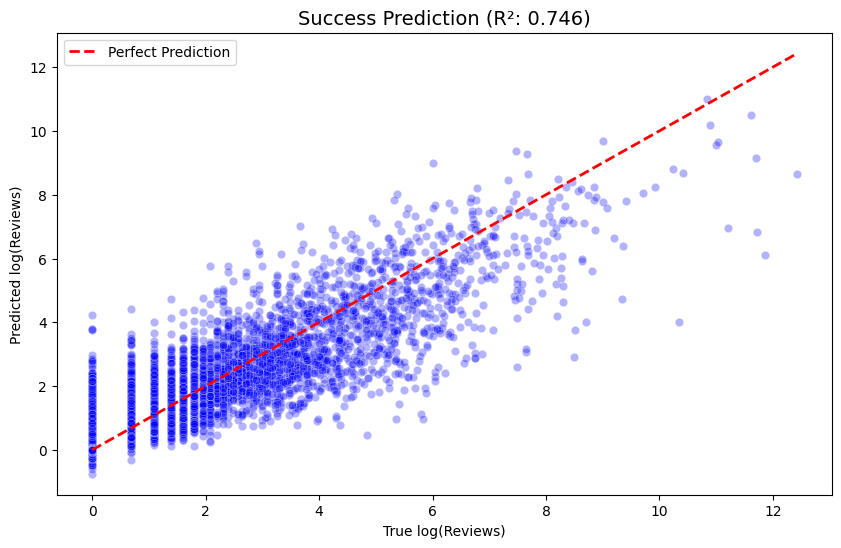

Exemples de prédictions :
                      Titre  Vrai_Avis   Prediction
49764  PamPam Kana Students          2     2.262399
54559   Smoots Summer Games          4     2.616455
72472               ホロウドライヴ          0    -0.035826
4886             Spectrubes          1    81.964386
21241             Time Rift         18    39.217973
11106              Squarism         18    15.669654
16201           The Tenants       3563  1035.318436
6394              Tavernier        106    21.206688
80580          Loot of Idle          0    -0.030343
44287              me Igigu          3     9.654875
               Feature Id  Importances
0              categories    23.285580
1       tags_utilisateurs    19.617371
2                    prix    17.843202
3                   annee    12.623909
4           nombre_succes     7.140610
5   description_detaillee     6.343750
6                  genres     3.039887
7                    mois     2.573836
8         langues_partiel     2.507940
9       N_la

In [16]:
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

y_test_original_scale = dft[target].copy()
y_test_eval = np.log1p(y_test_original_scale)

cb = CatBoostRegressor(
    depth=10,
    text_features=cols_text,
    verbose=100,
    task_type="GPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train)


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(y_test_eval, y_pred_log)
y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test_original_scale, y_pred)))
print("RMSE log :", np.sqrt(mean_squared_error(y_test_eval, y_pred_log)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test_original_scale, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_eval, y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, y_test_eval.max()], [0, y_test_eval.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title(f"Success Prediction (R²: {score_r2:.3f})", fontsize=14)
plt.xlabel("True log(Reviews)")
plt.ylabel("Predicted log(Reviews)")
plt.legend()
plt.show()

results = pd.DataFrame({
    'Titre': dft.loc[X_test.index, 'nom'] if 'nom' in dft.columns else X_test.index,
    'Vrai_Avis': y_test_original_scale,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)